In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

QAOA for MaxCut {#qaoa_rns}
===============

::: {.meta}
:property=\"og:description\": Implementing the quantum approximate
optimization algorithm using PennyLane to solve the MaxCut problem.
:property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets//qaoa_rns_partition.png>
:::

::: {.related}
tutorial\_qaoa\_intro Intro to QAOA
:::

*Author: Angus Lowe --- Posted: 11 October 2019. Last updated: 13 April
2021.*


In this tutorial we implement the quantum approximate optimization
algorithm (QAOA) for the MaxCut problem as proposed by [Farhi,
Goldstone, and Gutmann (2014)](https://arxiv.org/abs/1411.4028). First,
we give an overview of the MaxCut problem using a simple example, a
graph with 4 vertices and 4 edges. We then show how to find the maximum
cut by running the QAOA algorithm using PennyLane.

Background
==========

The MaxCut problem
------------------

The aim of MaxCut is to maximize the number of edges (yellow lines) in a
graph that are \"cut\" by a given partition of the vertices (blue
circles) into two sets (see figure below).

![](../_static/demonstration_assets/qaoa_rns/qaoa_rns_partition.png){.align-center}

| 

Consider a graph with $m$ edges and $n$ vertices. We seek the partition
$z$ of the vertices into two sets $A$ and $B$ which maximizes

$$C(z) = \sum_{\alpha=1}^{m}C_\alpha(z),$$

where $C$ counts the number of edges cut. $C_\alpha(z)=1$ if $z$ places
one vertex from the $\alpha^\text{th}$ edge in set $A$ and the other in
set $B$, and $C_\alpha(z)=0$ otherwise. Finding a cut which yields the
maximum possible value of $C$ is an NP-complete problem, so our best
hope for a polynomial-time algorithm lies in an approximate
optimization. In the case of MaxCut, this means finding a partition $z$
which yields a value for $C(z)$ that is close to the maximum possible
value.

We can represent the assignment of vertices to set $A$ or $B$ using a
bitstring, $z=z_1...z_n$ where $z_i=0$ if the $i^\text{th}$ vertex is in
$A$ and $z_i = 1$ if it is in $B$. For instance, in the situation
depicted in the figure above the bitstring representation is
$z=0101\text{,}$ indicating that the $0^{\text{th}}$ and $2^{\text{nd}}$
vertices are in $A$ while the $1^{\text{st}}$ and $3^{\text{rd}}$ are in
$B$. This assignment yields a value for the objective function (the
number of yellow lines cut) $C=4$, which turns out to be the maximum
cut. In the following sections, we will represent partitions using
computational basis states and use PennyLane to rediscover this maximum
cut.

::: {.note}
::: {.title}
Note
:::

In the graph above, $z=1010$ could equally well serve as the maximum
cut.
:::

A circuit for QAOA
------------------

This section describes implementing a circuit for QAOA using basic
unitary gates to find approximate solutions to the MaxCut problem.
Firstly, denoting the partitions using computational basis states
$|z\rangle$, we can represent the terms in the objective function as
operators acting on these states

$$C_\alpha = \frac{1}{2}\left(1-\sigma_{z}^j\sigma_{z}^k\right),$$

where the $\alpha\text{th}$ edge is between vertices $(j,k)$. $C_\alpha$
has eigenvalue 1 if and only if the $j\text{th}$ and $k\text{th}$ qubits
have different z-axis measurement values, representing separate
partitions. The objective function $C$ can be considered a diagonal
operator with integer eigenvalues.

QAOA starts with a uniform superposition over the $n$ bitstring basis
states,

$$|+_{n}\rangle = \frac{1}{\sqrt{2^n}}\sum_{z\in \{0,1\}^n} |z\rangle.$$

We aim to explore the space of bitstring states for a superposition
which is likely to yield a large value for the $C$ operator upon
performing a measurement in the computational basis. Using the $2p$
angle parameters $\boldsymbol{\gamma} = \gamma_1\gamma_2...\gamma_p$,
$\boldsymbol{\beta} = \beta_1\beta_2...\beta_p$ we perform a sequence of
operations on our initial state:

$$|\boldsymbol{\gamma},\boldsymbol{\beta}\rangle = U_{B_p}U_{C_p}U_{B_{p-1}}U_{C_{p-1}}...U_{B_1}U_{C_1}|+_n\rangle$$

where the operators have the explicit forms

$$\begin{aligned}
U_{B_l} &= e^{-i\beta_lB} = \prod_{j=1}^n e^{-i\beta_l\sigma_x^j}, \\
U_{C_l} &= e^{-i\gamma_lC} = \prod_{\text{edge (j,k)}} e^{-i\gamma_l(1-\sigma_z^j\sigma_z^k)/2}.
\end{aligned}$$

In other words, we make $p$ layers of parametrized $U_bU_C$ gates. These
can be implemented on a quantum circuit using the gates depicted below,
up to an irrelevant constant that gets absorbed into the parameters.

![](../_static/demonstration_assets/qaoa_rns/qaoa_operators.png){.align-center}

| 

Let $\langle \boldsymbol{\gamma},
\boldsymbol{\beta} | C | \boldsymbol{\gamma},\boldsymbol{\beta} \rangle$
be the expectation of the objective operator. In the next section, we
will use PennyLane to perform classical optimization over the circuit
parameters $(\boldsymbol{\gamma}, \boldsymbol{\beta})$. This will
specify a state $|\boldsymbol{\gamma},\boldsymbol{\beta}\rangle$ which
is likely to yield an approximately optimal partition $|z\rangle$ upon
performing a measurement in the computational basis. In the case of the
graph shown above, we want to measure either 0101 or 1010 from our state
since these correspond to the optimal partitions.

![](../_static/demonstration_assets/qaoa_rns/qaoa_optimal_state.png){.align-center}

| 

Qualitatively, QAOA tries to evolve the initial state into the plane of
the $|0101\rangle$, $|1010\rangle$ basis states (see figure above).

Implementing QAOA in PennyLane
==============================

Imports and setup
-----------------

To get started, we import PennyLane along with the PennyLane-provided
version of NumPy.


In [3]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
np.random.seed(42)

In [1]:
import numpy as np

# Define the matrix
matrix = np.array([[1/3, 1/3, -2/3, 1/3],
                   [-2/3, 1/3, 1/3, 1/3],
                   [1/3, -2/3, 1/3, 1/3],
                   [1/3, 1/3, 1/3, -2/3]])

# Calculate the inverse matrix
inverse_matrix = np.linalg.inv(matrix)

print("Inverse Matrix:")
print(inverse_matrix)


Inverse Matrix:
[[ 1.00000000e+00 -1.66533454e-16  1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00]]


Operators
=========

We specify the number of qubits (vertices) with `n_wires` and compose
the unitary operators using the definitions above. $U_B$ operators act
on individual wires, while $U_C$ operators act on wires whose
corresponding vertices are joined by an edge in the graph. We also
define the graph using the list `graph`, which contains the tuples of
vertices defining each edge in the graph.


In [4]:
def convert_to_bipartite(A):
    bip = nx.Graph()
    n = np.sqrt(A.size).astype(int)
    nodes_1 = list(range(0,n))
    nodes_2 = list(range(n,2*n))
    bip.add_nodes_from(nodes_1,bipartite=0)
    bip.add_nodes_from(nodes_2,bipartite=1)
    for i in range(n):
        for j in range(n,2*n):
            bip.add_edge(i,j,weight = A[i,j-n])
    
    pos = nx.bipartite_layout(bip,nodes_1)
    return bip,pos

#define Graph
A_m2 = np.array([[1,0,1,1],[1,1,1,1],[0,1,1,1],[1,1,1,1]])
#A_m2 = np.array([[1,1],[0,1]])
G,pos = convert_to_bipartite(A_m2)
dimension = np.sqrt(A_m2.size).astype(int) #matrix dimension

edges = list(G.edges())
weighted_edges = nx.get_edge_attributes(G, 'weight')
#print(weighted_edges)#printing the edges and the according weights (matrix entrys)

#define uncertainty
Delta = np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]])
#Delta = np.array([[1,1],[1,1]])
G_D,pos_D = convert_to_bipartite(Delta)

edges_D = list(G_D.edges())
weighted_edges_D = nx.get_edge_attributes(G_D, 'weight')
#print(weighted_edges_D)

In [5]:
n_wires = 2*dimension
graph = [(0, 1), (0, 3), (1, 2), (2, 3)]

# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in edges:
        wire1 = edge[0]
        wire2 = edge[1]
        weight_A = weighted_edges[edge]
        weight_Delta = weighted_edges_D[edge] #new imposed weight from uncertainty description
        weight = weight_A*weight_Delta
        #JAN addd appropriate weight with weight = weight_A*weight_Delta and adressed wires according to Theorem 5
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma*weight, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

We will need a way to convert a bitstring, representing a sample of
multiple qubits in the computational basis, to integer or base-10 form.


In [6]:
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

Circuit
=======

Next, we create a quantum device with 4 qubits.


In [7]:
dev = qml.device("lightning.qubit", wires=n_wires, shots=1)

We also require a quantum node which will apply the operators according
to the angle parameters, and return the expectation value of the
observable $\sigma_z^{j}\sigma_z^{k}$ to be used in each term of the
objective function later on. The argument `edge` specifies the chosen
edge term in the objective function, $(j,k)$. Once optimized, the same
quantum node can be used for sampling an approximately optimal bitstring
if executed with the `edge` keyword set to `None`. Additionally, we
specify the number of layers (repeated applications of $U_BU_C$) using
the keyword `n_layers`.


In [8]:
@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample()
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)

Optimization
============

Finally, we optimize the objective over the angle parameters
$\boldsymbol{\gamma}$ (`params[0]`) and $\boldsymbol{\beta}$
(`params[1]`) and then sample the optimized circuit multiple times to
yield a distribution of bitstrings. One of the optimal partitions
($z=0101$ or $z=1010$) should be the most frequently sampled bitstring.
We perform a maximization of $C$ by minimizing $-C$, following the
convention that optimizations are cast as minimizations in PennyLane.


In [9]:
def qaoa_rns(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in edges:
            # objective for the MaxCut problem
            weight_A = weighted_edges[edge]
            weight_Delta = weighted_edges_D[edge] #new imposed weight from uncertainty description
            weight = weight_A*weight_Delta
            neg_obj -= weight*circuit(gammas, betas, edge=edge, n_layers=n_layers)
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 100
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return -objective(params), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
bitstrings1 = qaoa_rns(n_layers=1)[1]
bitstrings2 = qaoa_rns(n_layers=4)[1]


p=1
Objective after step     5: -6.0000000
Objective after step    10:  20.0000000
Objective after step    15: -16.0000000
Objective after step    20: -8.0000000
Objective after step    25: -16.0000000
Objective after step    30: -2.0000000
Objective after step    35:  16.0000000
Objective after step    40:  6.0000000
Objective after step    45: -6.0000000
Objective after step    50: -10.0000000
Objective after step    55:  8.0000000
Objective after step    60:  6.0000000
Objective after step    65: -18.0000000
Objective after step    70: -2.0000000
Objective after step    75:  10.0000000
Objective after step    80:  8.0000000
Objective after step    85:  4.0000000
Objective after step    90: -2.0000000
Objective after step    95: -2.0000000
Objective after step   100: -2.0000000
Optimized (gamma, beta) vectors:
[[-1.38098022]
 [ 0.507885  ]]
Most frequently sampled bit string is: 1110111

p=4
Objective after step     5:  2.0000000
Objective after step    10:  22.0000000
Objective aft

In the case where we set `n_layers=2`, we recover the optimal objective
function $C=4$


Plotting the results
====================

We can plot the distribution of measurements obtained from the optimized
circuits. As expected for this graph, the partitions 0101 and 1010 are
measured with the highest frequencies, and in the case where we set
`n_layers=2` we obtain one of the optimal partitions with 100%
certainty.


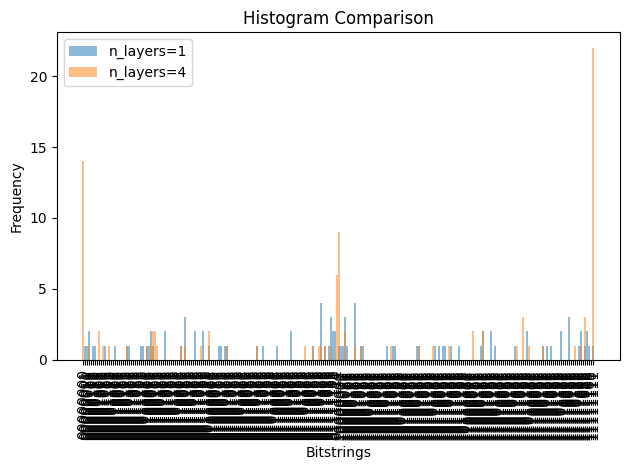

In [22]:
import matplotlib.pyplot as plt

xticks = range(0, 2**n_wires)
xtick_labels = list(map(lambda x: format(x, "08b"), xticks))
bins = np.arange(0, 2**n_wires + 1) - 0.5

plt.title("Histogram Comparison")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")

plt.hist(bitstrings1, bins=bins, alpha=0.5, label="n_layers=1")  # Plot first histogram
plt.hist(bitstrings2, bins=bins, alpha=0.5, label="n_layers=4")  # Plot second histogram

plt.legend()  # Display legend

plt.tight_layout()
plt.show()

About the author
================
